# eBay Pokémon Listing Analysis

This notebook analyzes eBay listings for the Pokémon product: **Prismatic Evolutions Super Premium Collection**, with a focus on whether **listing quality** and **seller reputation** affect listing prices.

## Data Collection

We use eBay's **Browse API** to retrieve up to 1,000 listings matching specific search criteria:

- Product: Pokemon Prismatic Evolutions Super Premium Collection
- Format: Fixed-price listings
- Category: Collectible Card Games
- Condition: New

The JSON response is parsed and stored in a Pandas DataFrame.

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

access_token = 'your_ebay_access_token_here'
headers = {'Authorization':f'Bearer {access_token}'}

df = pd.DataFrame()
offset = 0
while offset < 1000:
    url = f'https://api.ebay.com/buy/browse/v1/item_summary/search?q=pokemon+prismatic+evolutions+super+premium+collection+-lot+-case+-bundle+-x+-presale&limit=200&offset={offset}&category_ids=2536&filter=conditionIds:1000,priceCurrency:USD,buyingOptions:FIXED_PRICE'
    response = requests.get(url, headers=headers)
    data = response.json()
    items = data.get("itemSummaries", [])
    df_temp = pd.DataFrame(items)
    df = pd.concat([df, df_temp])
    offset+=200

## Understanding and Cleaning the Data

Here we analyze the structure of the data and clean it to ensure that we're only analyzing relevant listings.

### Goals:
- Identify and remove listings that are single quanitity but indicate "bundles," or multiple sets/boxes in the same listing for sale (e.g., "2 boxes", "three sets")
- Reset the DataFrame index to match their corresponding positions
- Extract listing prices into a new DataFrame

We also define a helper function `extract_prices()` to simplify working with the price data.

In [60]:
print(df.columns)

print(df['title'])

filtered_numbers = r'[0-9]|[0️⃣1️⃣2️⃣3️⃣4️⃣5️⃣6️⃣7️⃣8️⃣9️⃣]|\bone\b|\btwo\b|\bthree\b|\bfour\b|\bfive\b|\bsix\b|\bseven\b|\beight\b|\bnine\b|\bten\b'

# Filter out listings that mention multiple boxes (e.g. "2 boxes", "three, "six")
df = df[~df['title'].str.contains(filtered_numbers, regex=True, case=False)]

df = df.reset_index(drop=True)

def extract_prices(df):
    return [float(priceDict['value']) for priceDict in df['price']]
    
prices = extract_prices(df)
df_price = pd.DataFrame(prices, columns=['prices'])

df_price_top_15 = df_price.nlargest(15, 'prices')
print(df_price_top_15)

max_price_index = df_price['prices'].idxmax()
df = df.drop(index=max_price_index).reset_index(drop=True)

prices = extract_prices(df) 
df_price = pd.DataFrame(prices, columns=['prices'])
df_price.max()

Index(['itemId', 'title', 'leafCategoryIds', 'categories', 'image', 'price',
       'itemHref', 'seller', 'condition', 'conditionId', 'thumbnailImages',
       'shippingOptions', 'buyingOptions', 'epid', 'itemWebUrl',
       'itemLocation', 'additionalImages', 'adultOnly', 'legacyItemId',
       'availableCoupons', 'itemOriginDate', 'itemCreationDate',
       'topRatedBuyingExperience', 'priorityListing', 'listingMarketplaceId',
       'pickupOptions', 'marketingPrice', 'bidCount', 'currentBidPrice',
       'itemEndDate', 'itemGroupHref', 'itemGroupType'],
      dtype='object')
0      Pokemon Prismatic Evolutions Super Premium Col...
1      Prismatic Evolutions Super Premium Collection ...
2      Pokemon Prismatic Evolutions Super Premium Col...
3      Prismatic Evolutions Super Premium Collection ...
4      Pokemon Prismatic Evolutions Super Premium Col...
                             ...                        
195    Prismatic Evolutions Super Premium Collection ...
196    Pokemon T

prices    600.0
dtype: float64

## Splitting Listings by Seller Quality

We split listings by two indicators of seller trust:

1. **Top-Rated Plus** — based on eBay's internal designation.
2. **Top Sellers** — based on seller feedback metrics.

### Top-Rated Plus vs Non Top-Rated Plus

This section splits listings based on the `topRatedBuyingExperience` field from eBay's API. This is a boolean value, where True indicates that the listing is a 'top-rated plus item.'

A listing is labeled as a 'Top-Rated Plus item' if it meets strict eBay criteria:
- A **minimum 30-day money-back return policy**
- **Shipping within 1 business day** (with tracking)
- Sold by an **experienced seller with the highest buyer ratings**

These listings may command higher prices due to the added reliability, convienence, and trust.

In [61]:
top_rated_plus = df[df['topRatedBuyingExperience']==True]
not_top_rated_plus = df[df['topRatedBuyingExperience']==False]

top_rated_plus_prices = extract_prices(top_rated_plus)
top_rated_plus_listings_sample_size = len(top_rated_plus_prices)

non_top_rated_plus_prices = extract_prices(not_top_rated_plus)
non_top_rated_plus_listings_sample_size = len(non_top_rated_plus_prices)

print(top_rated_plus_listings_sample_size)
print(non_top_rated_plus_listings_sample_size)

16
879


## Top Sellers vs Non Top Sellers

We defined **Top Sellers** as those with:
- Feedabck Percentage ≥ 99%
- Feedback score ≥ 100

These thresholds identify reputable sellers with consistently high performance.

We create:
- A `top_sellers_df` DataFrame containing listings from top sellers
- A `non_top_sellers_df` DataFrame for all others

We also extract price data and count how many listings fall into each group.

In [62]:
# Checking the entry format of the seller column
df.loc[0, 'seller']

top_seller_indicies = [i for i, dict in enumerate(df['seller']) if float(dict['feedbackPercentage'])>=99.0 and float(dict['feedbackScore'])>=100.0]
print(len(top_seller_indicies))

top_sellers_df = df.iloc[top_seller_indicies]
non_top_seller_df = df.drop(index=top_seller_indicies)

top_seller_prices = extract_prices(top_sellers_df)
top_seller_sample_size = len(top_seller_prices)

non_top_seller_prices = extract_prices(non_top_seller_df)
non_top_seller_sample_size = len(non_top_seller_prices)

312


## Statistical Evaluation

We compute summuary statistics for each seller group to evaulate price differences (mean, median, min, max). We will also conduct a Mann-Whitney U test on both sets of listings to test for statistical significance.

In [63]:
def price_stats(set):
    mean = np.mean(set)
    median = np.median(set)
    min_price = np.min(set)
    max_price = np.max(set)
    return mean, median, min_price, max_price

def mannwhitneyu_test(group_a, group_b):
    _, p = mannwhitneyu(group_a, group_b, alternative='two-sided')
    return p

### Top-Rated Plus vs Non Top-Rated Plus Statistical Evaluation

We compare the price distributions between top-rated plus listings and all others. This allows us to evaluate whether eBay's quality label correlates with higher prices.

In [64]:
trps_mean, trps_median, trps_min, trps_max = price_stats(top_rated_plus_prices)
ntrps_mean, ntrps_median, ntrps_min, ntrps_max = price_stats(non_top_rated_plus_prices)

print("Top-Rated Plus Sample Size:", top_rated_plus_listings_sample_size)
print("Non-Top-Rated Plus Sample Size:", non_top_rated_plus_listings_sample_size, '\n')

print("Top-Rated Plus Mean:", trps_mean)
print("Top-Rated Plus Median:", trps_median)
print("Top-Rated Plus Min:", trps_min)
print("Top-Rated Plus Max:", trps_max, "\n")

print("Non Top-Rated Plus Plus Mean:", ntrps_mean)
print("Non Top-Rated Plus Plus Median:", ntrps_median)
print("Non Top-Rated Plus Plus Min:", ntrps_min)
print("Non Top-Rated Plus Plus Max:", ntrps_max, "\n")

trp_vs_ntrp_p = mannwhitneyu_test(top_rated_plus_prices, non_top_rated_plus_prices)

print("Mann-Whitney U P-value:", trp_vs_ntrp_p)

Top-Rated Plus Sample Size: 16
Non-Top-Rated Plus Sample Size: 879 

Top-Rated Plus Mean: 202.036875
Top-Rated Plus Median: 232.0
Top-Rated Plus Min: 24.95
Top-Rated Plus Max: 280.0 

Non Top-Rated Plus Plus Mean: 196.84637087599543
Non Top-Rated Plus Plus Median: 210.0
Non Top-Rated Plus Plus Min: 3.36
Non Top-Rated Plus Plus Max: 600.0 

Mann-Whitney U P-value: 0.2077934584671408


## Top Sellers vs Non Top Sellers Statistical Evaluation

In [65]:
ts_mean, ts_median, ts_min, ts_max = price_stats(top_seller_prices)
nts_mean, nts_median, nts_min, nts_max = price_stats(non_top_seller_prices)

print("Top-Seller Sample Size:", top_seller_sample_size)
print("Non-Top-Seller Sample Size:", non_top_seller_sample_size, '\n')

print("Top-Sellers Mean:", ts_mean)
print("Top-Sellers Median:", ts_median)
print("Top-Sellers Min:", ts_min)
print("Top-Sellers Max:", ts_max, "\n")

print("Non Top-Sellers Mean:", nts_mean)
print("Non Top-Sellers Median:", nts_median)
print("Non Top-Sellerss Min:", nts_min)
print("Non Top-Sellers Max:", nts_max, "\n")

ts_vs_non_ts_p = mannwhitneyu_test(top_seller_prices, non_top_seller_prices)

print("Mann-Whitney U P-value:", ts_vs_non_ts_p)

Top-Seller Sample Size: 312
Non-Top-Seller Sample Size: 583 

Top-Sellers Mean: 199.90493589743588
Top-Sellers Median: 211.51999999999998
Top-Sellers Min: 3.36
Top-Sellers Max: 600.0 

Non Top-Sellers Mean: 195.3519897084048
Non Top-Sellers Median: 210.0
Non Top-Sellerss Min: 7.99
Non Top-Sellers Max: 550.0 

Mann-Whitney U P-value: 0.34372147049407753


## Visualizations

We use boxplots and KDE plots to compare price distributions

## Boxplot: Top-Rated Plus vs Non Top-Rated Plus

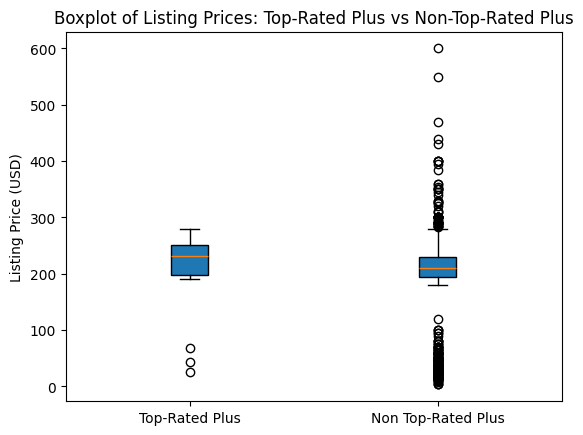

In [70]:
data = [top_rated_plus_prices, non_top_rated_plus_prices]
labels = ['Top-Rated Plus', 'Non Top-Rated Plus']

plt.boxplot(data, tick_labels=labels, patch_artist=True)
plt.ylabel('Listing Price (USD)')
plt.title('Boxplot of Listing Prices: Top-Rated Plus vs Non-Top-Rated Plus')
plt.savefig("boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

KDE plot visualization for top-seller groups

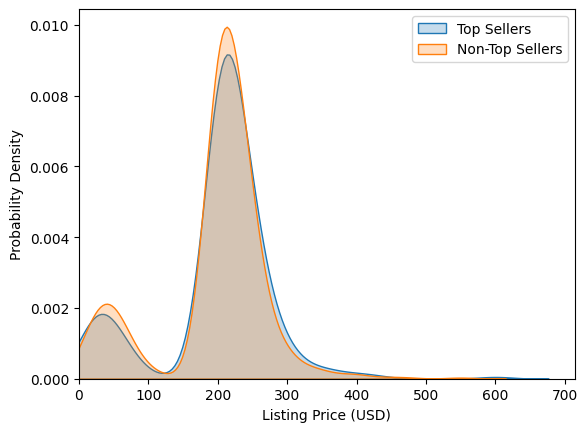

In [72]:
sns.kdeplot(data=top_seller_prices, label='Top Sellers', fill=True)
sns.kdeplot(data=non_top_seller_prices, label='Non-Top Sellers', fill=True)
plt.legend()
plt.xlim(left=0)
plt.ylabel('Probability Density')
plt.xlabel('Listing Price (USD)')
plt.savefig("kde_plot.png", dpi=300, bbox_inches='tight')
plt.show()

## Summary

**Top-Rated Plus vs Not-Top-Rated Plus listings**

It is important to note the substantial imbalance in sample sizes between the Top-Rated Plus and Non-Top-Rated Plus groups: the former includes only 16 listings, while the latter includes 879. This discrepancy warrants cautious interpretation.

Summary statistics — including the mean, median, minimum, and maximum listing prices — were calculated for each group. The Top-Rated Plus group showed slightly higher mean, median, and minimum values. However, its maximum listing price (280) was significantly lower than that of the Non-Top-Rated Plus group (600).

While the median prices between the two groups are relatively similar, there is a notable difference in price distribution. The Top-Rated Plus listings display a tighter, more consistent spread, whereas the Non-Top-Rated Plus listings show greater variability and a larger number of outliers.

At first glance, there appears to be some evidence of pricing variability between Top-Rated Plus and Non-Top-Rated Plus item listings. However, given the large disparity in sample sizes, these patterns may not accurately reflect a true relationship — if any — between the two groups.

A Mann-Whitney U test was conducted to assess whether the difference in listing price distributions between the Top-Rated Plus and Non-Top-Rated Plus groups was statistically significant. The resulting p-value was approximately 0.208, which is well above the conventional significance threshold (e.g., α = 0.05).

This suggests that there is no statistically significant difference in the distribution of listing prices between the two groups.

Combined with the substantial sample size imbalance (16 vs 879), this result further supports the conclusion that any observed differences in spread or central tendency should be interpreted with caution, and may not reflect a true underlying difference in pricing behavior.

**Top Sellers vs Non-Top Sellers**

Based on a sample of 312 Top Seller listings and 583 Non-Top Seller listings, there is no significant difference in listing price distributions between the two groups. Both groups have nearly identical medians (210 and 211), slightly differing means (~199 vs 195), and similar minimum/maximum values.

The KDE plot shows a high degree of overlap, indicating that the overall shape and spread of the distributions are nearly indistinguishable.

Additionally, the Mann-Whitney U test yielded a p-value of 0.344, confirming that the observed differences are not statistically significant.

These findings suggest that Top Seller status, as defined in this dataset, does not appear to influence listing price in a meaningful way.

**Overall Conclusion**

These findings suggest that, for this specific Pokémon item, seller designation — whether "Top-Rated Plus" or "Top Seller" — does not significantly influence how the item is priced. While small visual differences in price distribution appeared in the smaller group (Top-Rated Plus), statistical testing did not support any meaningful difference in listing prices across seller statuses.